In [29]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree, export_text

from joblib import dump

In [2]:
hotel_df = pd.read_csv('Hotel Reservations.csv')
hotel_df.drop(['Booking_ID'], inplace=True, axis=1)

In [35]:
categorical_vars = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type']
numerical_vars = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
time_vars = ['arrival_year', 'arrival_month', 'arrival_date']

excluded_vars = ['arrival_year']

included_categorical_vars = [var for var in categorical_vars if var not in excluded_vars]
included_numerical_vars = [var for var in numerical_vars if var not in excluded_vars]
included_time_vars = [var for var in time_vars if var not in excluded_vars]

X = hotel_df.drop(['booking_status'] + excluded_vars, axis=1)
y = hotel_df['booking_status']

### load feature transformer
scaler = pickle.load(open('Models/scaler.pkl', 'rb'))
X_scaled = scaler.transform(X)

# transformed_columns = scaler.get_feature_names_out()
# transformed_columns = [re.split(r',*__', col)[1] for col in transformed_columns]
# X_scaled = pd.DataFrame(X_scaled, columns=transformed_columns)

y_bin = LabelBinarizer().fit_transform(y)
# y_bin = pd.DataFrame(y_bin, columns=[y.name])

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_bin, test_size=0.2, random_state=92)

### GridSearch for Pre-Pruning

In [34]:
dt_grid = DecisionTreeClassifier(random_state=12)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 16),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': np.concatenate([[None, 'sqrt', 'log2'], np.arange(1, X_train.shape[1])])
}

grid = GridSearchCV(estimator=dt_grid, param_grid=param_grid, n_jobs=6, cv=3)

grid_result = grid.fit(X_train, y_train)

print("Best parameters: ", grid_result.best_params_)
print("Best accuracy: {:.2f}%".format(grid_result.best_score_ * 100))

Best parameters:  {'criterion': 'gini', 'max_depth': 11, 'max_features': 28, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best accuracy: 87.22%


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Training Accuracy:  89.09%
Testing Accuracy:  87.39%
Difference: 1.71%
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      8948
           1       0.93      0.91      0.92     20072

    accuracy                           0.89     29020
   macro avg       0.87      0.88      0.87     29020
weighted avg       0.89      0.89      0.89     29020



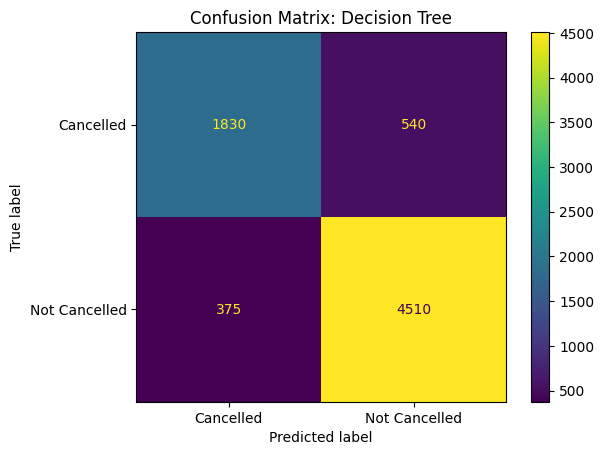

In [36]:
dt_pre = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=11, min_samples_split=9, min_samples_leaf=1, max_features=28, random_state=12)

dt_pre.fit(X_train, y_train)


### determine predicted values
dt_pre_train_pred = dt_pre.predict(X_train)
dt_pre_test_pred = dt_pre.predict(X_test)

### accuracy
dt_pre_train_acc = accuracy_score(y_train, dt_pre_train_pred)
dt_pre_test_acc = accuracy_score(y_test, dt_pre_test_pred)
print(f"Training Accuracy:  {100*dt_pre_train_acc:.2f}%")
print(f"Testing Accuracy:  {100*dt_pre_test_acc:.2f}%")
print(f"Difference: {(100*dt_pre_train_acc - 100*dt_pre_test_acc):.2f}%")
print(classification_report(dt_pre_test_pred, y_test))

dt_pre_cm = confusion_matrix(y_test, dt_pre_test_pred)
dt_pre_cm_disp = ConfusionMatrixDisplay(dt_pre_cm, display_labels=['Cancelled', 'Not Cancelled'])
dt_pre_cm_disp.plot()
plt.title('Confusion Matrix: Decision Tree')
plt.show()

In [37]:
# save file w/ joblib
dump(dt_pre, 'Decision Trees/DT_Pre.joblib')

['Decision Trees/DT_Pre.joblib']

### Post-Pruning

code taken from https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

In [6]:
dt_post = DecisionTreeClassifier(random_state=12)
path = dt_post.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

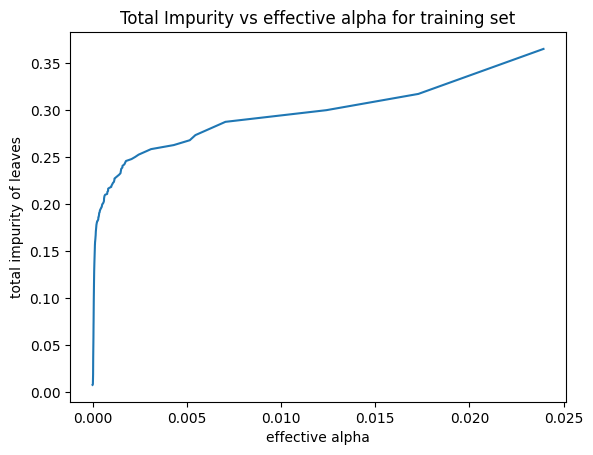

In [7]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1])
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [8]:
dts = []

for ccp_alpha in tqdm(ccp_alphas):
    dt = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=12)
    dt.fit(X_train, y_train)
    dts.append(dt)

100%|██████████| 1506/1506 [02:59<00:00,  8.41it/s]


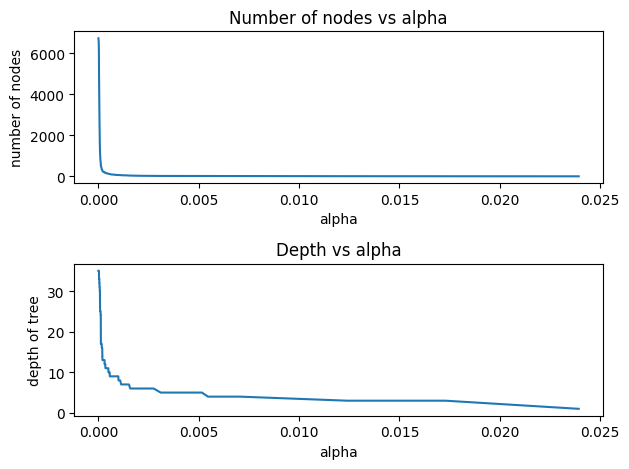

In [9]:
dts = dts[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [dt.tree_.node_count for dt in dts]
depth = [dt.tree_.max_depth for dt in dts]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth)
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

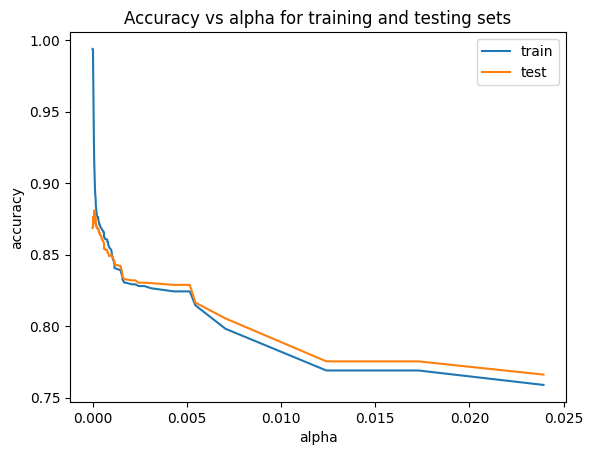

In [10]:
train_scores = [dt.score(X_train, y_train) for dt in dts]
test_scores = [dt.score(X_test, y_test) for dt in dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, label="train")
ax.plot(ccp_alphas, test_scores, label="test")
ax.legend()
plt.show()

In [11]:
alpha_max = ccp_alphas[np.argmax(test_scores)]

Training Accuracy:  90.98%
Testing Accuracy:  88.08%
Difference: 2.90%
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      8734
           1       0.95      0.92      0.93     20286

    accuracy                           0.91     29020
   macro avg       0.89      0.91      0.90     29020
weighted avg       0.91      0.91      0.91     29020



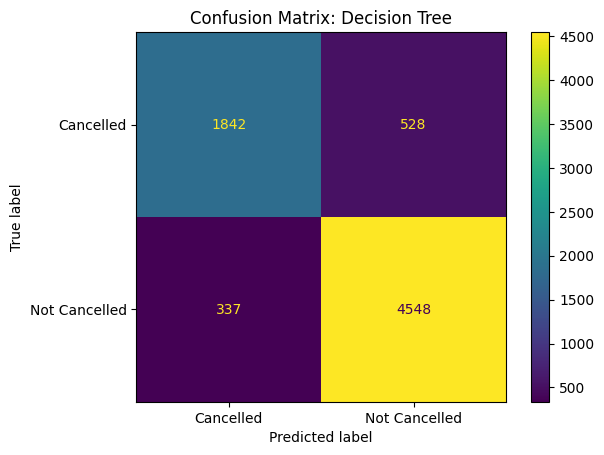

In [38]:
dt_post = DecisionTreeClassifier(ccp_alpha=alpha_max, random_state=12)

dt_post.fit(X_train, y_train)


### determine predicted values
dt_post_train_pred = dt_post.predict(X_train)
dt_post_test_pred = dt_post.predict(X_test)

### accuracy
dt_post_train_acc = accuracy_score(y_train, dt_post_train_pred)
dt_post_test_acc = accuracy_score(y_test, dt_post_test_pred)
print(f"Training Accuracy:  {100*dt_post_train_acc:.2f}%")
print(f"Testing Accuracy:  {100*dt_post_test_acc:.2f}%")
print(f"Difference: {(100*dt_post_train_acc - 100*dt_post_test_acc):.2f}%")
print(classification_report(dt_post_test_pred, y_test))

dt_post_cm = confusion_matrix(y_test, dt_post_test_pred)
dt_post_cm_disp = ConfusionMatrixDisplay(dt_post_cm, display_labels=['Cancelled', 'Not Cancelled'])
dt_post_cm_disp.plot()
plt.title('Confusion Matrix: Decision Tree')
plt.show()

In [39]:
# save file w/ joblib
dump(dt_post, 'Decision Trees/DT_post.joblib')

['Decision Trees/DT_post.joblib']

### Combine Results from Pre- & Post-Pruning

In [14]:
dt_both = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=11, min_samples_split=9, min_samples_leaf=1, max_features=28, random_state=12)
path_both = dt_both.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas_both, impurities_both = path_both.ccp_alphas, path_both.impurities

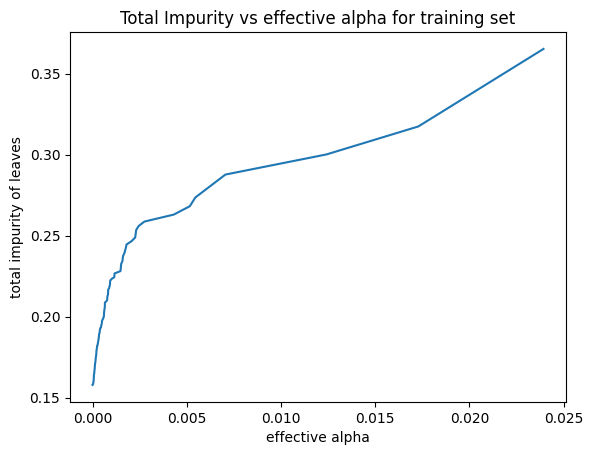

In [15]:
fig_both, ax_both = plt.subplots()
ax_both.plot(ccp_alphas_both[:-1], impurities_both[:-1])
ax_both.set_xlabel("effective alpha")
ax_both.set_ylabel("total impurity of leaves")
ax_both.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [23]:
dts_both = []

for ccp_alpha in tqdm(ccp_alphas_both):
    dt = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=12)
    dt.fit(X_train, y_train)
    dts_both.append(dt)

100%|██████████| 276/276 [00:31<00:00,  8.64it/s]


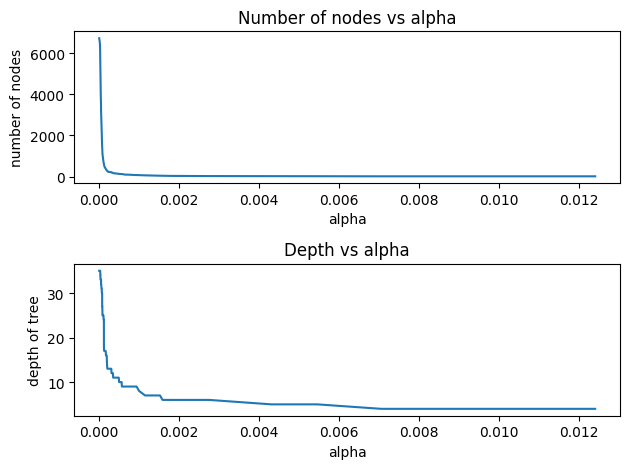

In [24]:
dts_both = dts_both[:-1]
ccp_alphas_both = ccp_alphas_both[:-1]

node_counts_both = [dt.tree_.node_count for dt in dts_both]
depth_both = [dt.tree_.max_depth for dt in dts_both]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas_both, node_counts_both)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas_both, depth_both)
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

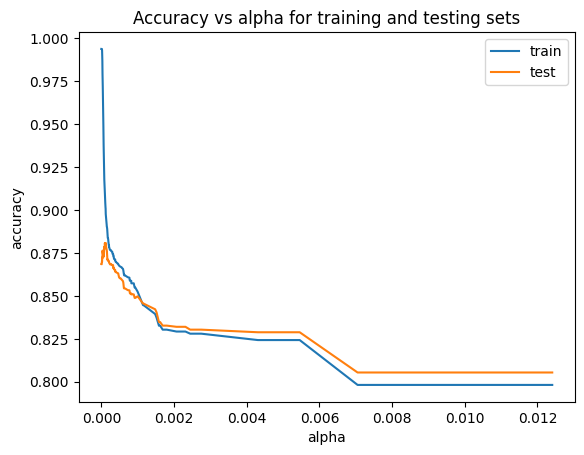

In [25]:
train_scores_both = [dt.score(X_train, y_train) for dt in dts_both]
test_scores_both = [dt.score(X_test, y_test) for dt in dts_both]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas_both, train_scores_both, label="train")
ax.plot(ccp_alphas_both, test_scores_both, label="test")
ax.legend()
plt.show()

In [26]:
alpha_max_both = ccp_alphas_both[np.argmax(test_scores_both)]

Training Accuracy:  88.71%
Testing Accuracy:  87.42%
Difference: 1.30%
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      8809
           1       0.93      0.90      0.92     20211

    accuracy                           0.89     29020
   macro avg       0.86      0.88      0.87     29020
weighted avg       0.89      0.89      0.89     29020



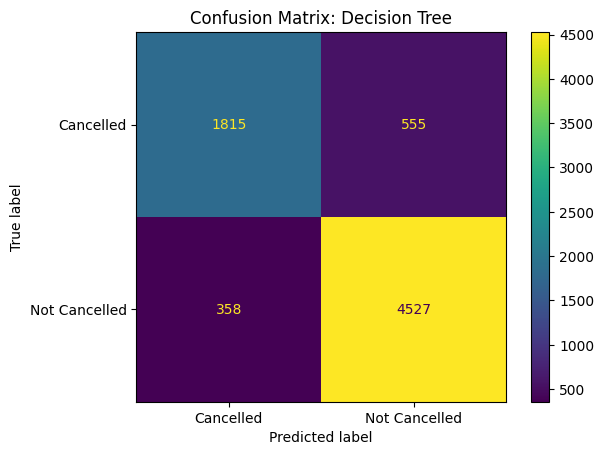

In [40]:
dt_both = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=11, min_samples_split=9, min_samples_leaf=1, max_features=28, ccp_alpha=alpha_max_both, random_state=12)

dt_both.fit(X_train, y_train)

### determine predicted values
dt_both_train_pred = dt_both.predict(X_train)
dt_both_test_pred = dt_both.predict(X_test)

### accuracy
dt_both_train_acc = accuracy_score(y_train, dt_both_train_pred)
dt_both_test_acc = accuracy_score(y_test, dt_both_test_pred)
print(f"Training Accuracy:  {100*dt_both_train_acc:.2f}%")
print(f"Testing Accuracy:  {100*dt_both_test_acc:.2f}%")
print(f"Difference: {(100*dt_both_train_acc - 100*dt_both_test_acc):.2f}%")
print(classification_report(dt_both_train_pred, y_train))

dt_both_cm = confusion_matrix(y_test, dt_both_test_pred)
dt_both_cm_disp = ConfusionMatrixDisplay(dt_both_cm, display_labels=['Cancelled', 'Not Cancelled'])
dt_both_cm_disp.plot()
plt.title('Confusion Matrix: Decision Tree')
plt.show()

In [41]:
# save file w/ joblib
dump(dt_both, 'Decision Trees/DT_both.joblib')

['Decision Trees/DT_both.joblib']